In [5]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL #einops
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

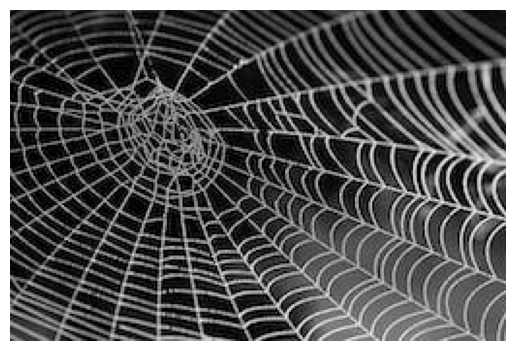

In [6]:
def download_image(url):
    imgb = fc.urlread(url, decode=False) 
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.
url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"
style_im = download_image(url).to(def_device)
show_image(style_im);

In [7]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def calc_features(imgs, target_layers=[18, 25]): 
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

# Batched version of the previous notebook's gram matrix function
def calc_grams(img, target_layers=[1, 6, 11, 18, 25]):
    return L(torch.einsum('bchw, bdhw -> cd', x, x) / (x.shape[-2]*x.shape[-1])
            for x in calc_features(img, target_layers))

class StyleLossToTarget():
    def __init__(self, target_im, target_layers=[1, 6, 11, 18, 25]):
        fc.store_attr()
        with torch.no_grad(): self.target_grams = calc_grams(target_im[None], target_layers)
    def __call__(self, input_im): 
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_grams(input_im, self.target_layers), self.target_grams))

In [8]:
style_loss = StyleLossToTarget(style_im)
style_loss(torch.rand(1, 3, 256, 256).to(def_device))

/home/metao/fastai2023/part2/.conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


tensor(1172.6400, device='cuda:0', grad_fn=<AddBackward0>)

In [9]:
num_channels = 4
hidden_n = 8

In [10]:
def make_grids(n, sz=128): return torch.zeros(n, num_channels, sz, sz).to(def_device)

In [11]:
# Hard-coded filters
filters = torch.stack([
    tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),
    tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),
    tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T,
    tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])
]).to(def_device)
     

In [12]:
filters.shape

torch.Size([4, 3, 3])

In [13]:
def perchannel_conv(x, filters):
    '''filters: [filter_n, h, w]'''
    b, ch, h, w = x.shape
    y = x.reshape(b*ch, 1, h, w)
    y = F.pad(y, [1, 1, 1, 1], 'circular') # << Note pad mode
    y = F.conv2d(y, filters[:,None])
    return y.reshape(b, -1, h, w)

In [15]:
make_grids(1).shape

torch.Size([1, 4, 128, 128])

In [16]:
def perchannel_conv(x, filters):
    '''filters: [filter_n, h, w]'''
    b, ch, h, w = x.shape
    y = x.reshape(b*ch, 1, h, w)
    y = F.pad(y, [1, 1, 1, 1], 'circular') # << Note pad mode
    y = F.conv2d(y, filters[:,None])
    return y.reshape(b, -1, h, w)

In [17]:
x = make_grids(1)
model_inputs = perchannel_conv(x, filters)
model_inputs.shape

torch.Size([1, 16, 128, 128])